In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from LSTM.ConvLSTM_2 import *
from tqdm import tqdm
from time import sleep
import math
from LSTM.torch_early_stopping import  EarlyStopping
import json 
import random
import matplotlib.pyplot as plt
from LSTM.opt_and_loss import mape, loss_fn
from LSTM.forecasting import forecast_runner

import seaborn as sns 
from IPython.display import clear_output

In [3]:
npy_path = '/content/drive/MyDrive/Colab Notebooks/datasets/qlstm_def'
test_data = ( np.load(npy_path+'/enc_in_test.npy'),
              np.load(npy_path+'/dec_in_test.npy'),
              np.load(npy_path+'/dec_out_test.npy') )
            

dec_in_min = np.load(npy_path+'/dec_in_min.npy')
dec_in_max = np.load(npy_path+'/dec_in_max.npy')

In [4]:
device = 'cpu'
if torch.cuda.is_available():
	torch.set_default_tensor_type(torch.cuda.FloatTensor)
	device = 'cuda'
	print('cuda avaible')

In [5]:
enc_in, dec_in, lab = test_data
enc_in, dec_in, lab = map ( lambda x : torch.from_numpy(x).float().to(device), [enc_in, dec_in, lab] )

In [6]:
n_batch_considered=25

In [7]:
enc_in=enc_in[16*5:16*30]
dec_in=dec_in[16*5:16*30]
lab=lab[16*5:16*30]

In [8]:
n_inputs =  enc_in.shape[2] #data_meta_info['n_inputs']
n_outputs = dec_in.shape[2] #data_meta_info['n_outputs']
window_dec = 5 #data_meta_info['window_dec']

# hidden_dimensions=[7,15,30,45]
# kernel_dim = 2

In [9]:
test_set = torch.utils.data.TensorDataset(enc_in, dec_in, lab)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 16)

In [11]:
mape_matrix=np.zeros((4,5))
rmse_matrix=np.zeros((4,5))
for i in range(4):
  hidden_dim=hidden_dimensions[i]
  for j in range(5):
    kernel_dim=2+j
    kernel_size=(kernel_dim,kernel_dim)
    model=EncDecConvLSTM( device, n_inputs, hidden_dim, n_outputs, kernel_size)
    saved_model_path=f"/content/drive/MyDrive/Colab Notebooks/Thesis utils/Models dict/Enc_Dec_3gates_C/{hidden_dim}_{kernel_dim}_ED3_LSTM_for.pt"
    model.load_state_dict( torch.load(saved_model_path , map_location=device) )
    model.to(device)
    pred,lab, pred_l, lab_l=forecast_runner(test_loader,model,device,window_dec,dec_in_min,dec_in_max,n_batch_considered)
    MAPE=mape(pred,lab)
    mape_mean=MAPE.mean()
    mape_max=MAPE.max()
    mape_min=MAPE.min()
    loss_mean=loss_fn(pred_l,lab_l)
    mse=torch.nn.MSELoss()
    rmse_mean=torch.sqrt(mse(lab_l,pred_l))
    test_meta_info = {}
    test_meta_info['MAPE_MAX']=str(mape_max)
    test_meta_info['MAPE_MEAN']=str(mape_mean)
    test_meta_info['MAPE_MIN']=str(mape_min)
    test_meta_info['LOG_COSH']=str(loss_mean)
    test_meta_info['RMSE']=str(rmse_mean)
    test_model_json_info_path = f'/content/drive/MyDrive/Colab Notebooks/Thesis utils/Test loss/EDC3/model_meta_info_{hidden_dim}_{kernel_dim}_ED3.json'
    with open(test_model_json_info_path, 'w') as fp:
        json.dump(test_meta_info, fp, indent=5)
    mape_matrix[i][j]=mape_mean
    rmse_matrix[i][j]=rmse_mean
  

path = f"/content/drive/MyDrive/Colab Notebooks/Thesis utils/MATRIX_TEST/EDC3"
np.save(f"{path}/mape_matrix.npy", mape_matrix)
np.save(f"{path}/rmse_matrix.npy", rmse_matrix)


In [12]:
pred_l.shape

torch.Size([400, 5, 1, 7, 7])

In [13]:
def dynamic_heatmaps(true, pred, n_data_show=0, delay=0.5, out_feature_show=0):
    pt= "/content/drive/MyDrive/Colab Notebooks/LSTM/predictions"
    true = true[n_data_show,:,out_feature_show,:,:]
    pred = pred[n_data_show,:,out_feature_show,:,:]

    vmax = max(true.max(), pred.max())
    vmin = min(true.min(), pred.min())

    for i in range(pred.shape[0]):

      clear_output(wait=True)
      time.sleep(delay)
      
      fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
      ax1, ax2 = axes

      true_temp=true[i,:,:]
      pred_temp=pred[i,:,:]

      # Heat maps.
      im1 = ax1.matshow(true_temp, cmap='coolwarm', vmin=vmin, vmax=vmax)
      im2 = ax2.matshow(pred_temp, cmap='coolwarm', vmin=vmin, vmax=vmax)

      # Formatting for heat map 1.
      # ax1.set_xticks(range(len(columns1)))
      # ax1.set_yticks(range(len(columns1)))
      # ax1.set_xticklabels(columns1)
      # ax1.set_yticklabels(columns1)
      # ax1.set_title(data1.name, y=-0.1)
      # plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
      plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

      # Formatting for heat map 2.
      # ax2.set_xticks(range(len(columns2)))
      # ax2.set_yticks(range(len(columns2)))
      # ax2.set_xticklabels(columns2)
      # ax2.set_yticklabels(columns2)
      # ax2.set_title(data2.name, y=-0.1)
      # plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
      plt.colorbar(im2, fraction=0.045, pad=0.05, ax=ax2)
      plt.savefig(pt+'/'+str(i)+'.JPG')

      fig.tight_layout()
      #display(fig)
      plt.show()


In [14]:
import time

In [15]:
_,_,test_label = test_data
#while True:
dynamic_heatmaps(lab_l, pred_l.detach().numpy(),278)

In [16]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
    frame_one = frames[0]
    frame_one.save("/content/drive/MyDrive/Colab Notebooks/LSTM/predictions/prova_4.gif", format="GIF", append_images=frames,
               save_all=True, duration=600, loop=0)
    
if __name__ == "__main__":
    make_gif("/content/drive/MyDrive/Colab Notebooks/LSTM/predictions")

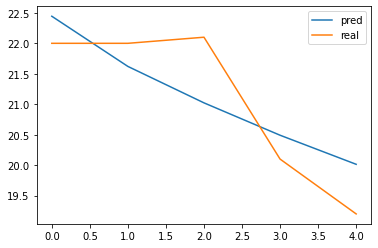

In [17]:
plt.plot(pred[1][1][8],label='pred')
plt.plot(lab[1][1][8],label='real')
plt.legend()

<Axes: title={'center': 'Enc3-C-LSTM MAPE'}>

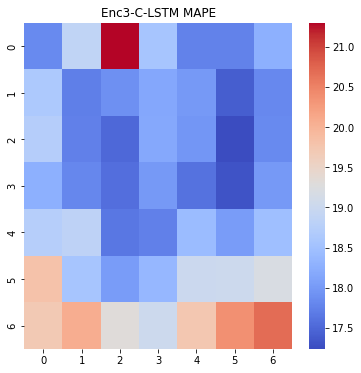

In [18]:
plt.figure(figsize=(6,6))
plt.title("Enc3-C-LSTM MAPE")
sns.heatmap(MAPE, annot=False, fmt=".3f",cmap='coolwarm')

In [19]:
mape_matrix[0][3]=18.7807632

In [20]:
mape_matrix.mean()

7.447677145615233

In [21]:
mape_matrix.std()

9.122076752985821

In [22]:
rmse_matrix.mean()

0.8392576217651367

In [23]:
np.std(rmse_matrix)

1.6785152435302735

In [24]:
log_cosh_matrix.mean()

0.5059128284454346

In [25]:
log_cosh_matrix.std()

1.0118256568908695